# Simulations from estimated parameters

In [1]:
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot(S=None,I=None,R=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    if S is not None:
        ax.plot(time_range, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    if I is not None:
        ax.plot(time_range, I, 'r', alpha=0.5, lw=2, label='Infected')
    if R is not None:
        ax.plot(time_range, R, 'g', alpha=0.5, lw=2, label='Recovered')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number of people')
    #ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

In [3]:
# Population parameters
N = 1000000
I0 = 1
R0 = 0
S0 = N - I0 - R0

## Disease parameters
# contact transmission probability
R0 = 2.28
# recovery rate
gamma = 1/14

beta = R0*gamma

## Simulation parameters
time_range = np.linspace(0,1000,1000)

## Distancing effect: fraction of baseline interactions
pi = np.ones(len(time_range))

In [4]:
## SIR Model (stationary, t for odeint compliance)
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [5]:
## Initial condition vector
y0 = (S0, I0, R0)

## Integrate
sim = odeint(deriv, y0, time_range, args=(N,beta,gamma))

## Get results
S,I,R = sim.T

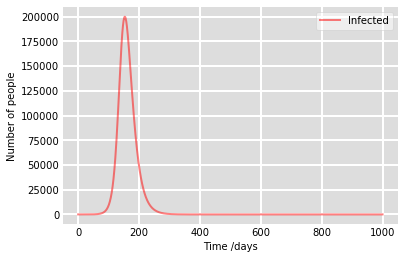

In [6]:
plot(I=I)

In [120]:
## SIR Model (stationary, t for odeint compliance)
def deriv(y, t, N, beta, gamma, pi):
    S, I, R = y
    #gamma = 1/max(np.random.normal(14,4), 7)
    #beta = max(1,np.random.normal(2.28, 1)) * gamma
    dSdt = -beta * S * I / N * pi[int(t)]
    dIdt = beta * S * I / N * pi[int(t)] - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def time_step(deriv, y0, ts, args):
    states = [np.asarray(y0)]
    for dt,t in zip(ts[1:] - ts[:-1], ts[1:]):
        curr = states[-1]
        derivatives = np.asarray(deriv(curr, t, *args))
        states.append(curr + derivatives*dt)

    return np.asarray(states)

In [121]:
## Initial condition vector
y0 = (S0, I0, R0)

pi = np.ones(len(time_range)+1)
## Integrate
#sim = odeint(deriv, y0, time_range, args=(N,beta,gamma))
sim = time_step(deriv, y0, time_range, args=(N,beta,gamma, pi))

## Get results
S,I,R = sim.T

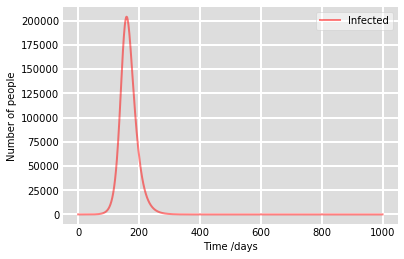

In [122]:
plot(I=I)

## With social distancing

In [152]:
def step(low, t0, ts):
    """
    low : the asymptotic reduced contact level
    t0 : when measure are implemented
    ts : the time range
    """
    pi = np.ones(len(ts) + 1)
    pi[t0:] = low/100

    return(pi)

def exp(low, dt, t0, ts):
    """
    low : the asymptotic reduced contact level
    dt : number of days to half the contact
    t0 : when measure are implemented
    ts : the time range
    """
    c = -np.log((2 - low/100) / (1 - low/100)) / dt
    pi = np.ones(len(ts) + 1)
    pi[t0:-1] = (1 - low/100) * np.exp(c*(ts[t0:]-ts[t0])) + low/100

    return(pi)


In [155]:
pi_dict = {
    "Baseline": np.ones(len(time_range)+1),
    "Step Drop to 50%": step(50, 100, time_range),
    "Exp Drop to 50%, 5 days": exp(50, 10, 100, time_range),
    "Exp Drop to 50%, 10 days": exp(50, 25, 100, time_range),
    "Exp Drop to 50%, 15 days": exp(50, 50, 100, time_range),
}

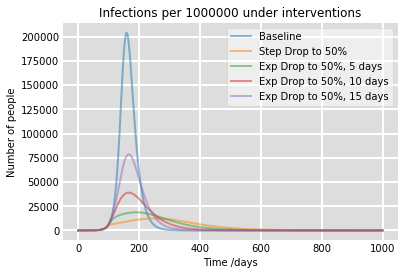

In [157]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)    

## Plot
for label, pi in pi_dict.items():
    sim = time_step(deriv, y0, time_range, args=(N,beta,gamma, pi))
    S,I,R = sim.T
    ax.plot(time_range, I, alpha=0.5, lw=2, label=label)

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of people')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.title(f"Infections per {N} under interventions")
plt.show()
